# CarND-Advanced-Lane-Lines 

## Camera Calibration

camera_cal/calibration10.jpg
camera_cal/calibration19.jpg
camera_cal/calibration9.jpg
camera_cal/calibration6.jpg
camera_cal/calibration3.jpg
camera_cal/calibration18.jpg
camera_cal/calibration15.jpg
camera_cal/calibration16.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration7.jpg
camera_cal/calibration13.jpg
camera_cal/calibration20.jpg
camera_cal/calibration2.jpg
camera_cal/calibration8.jpg
camera_cal/calibration14.jpg
camera_cal/calibration17.jpg


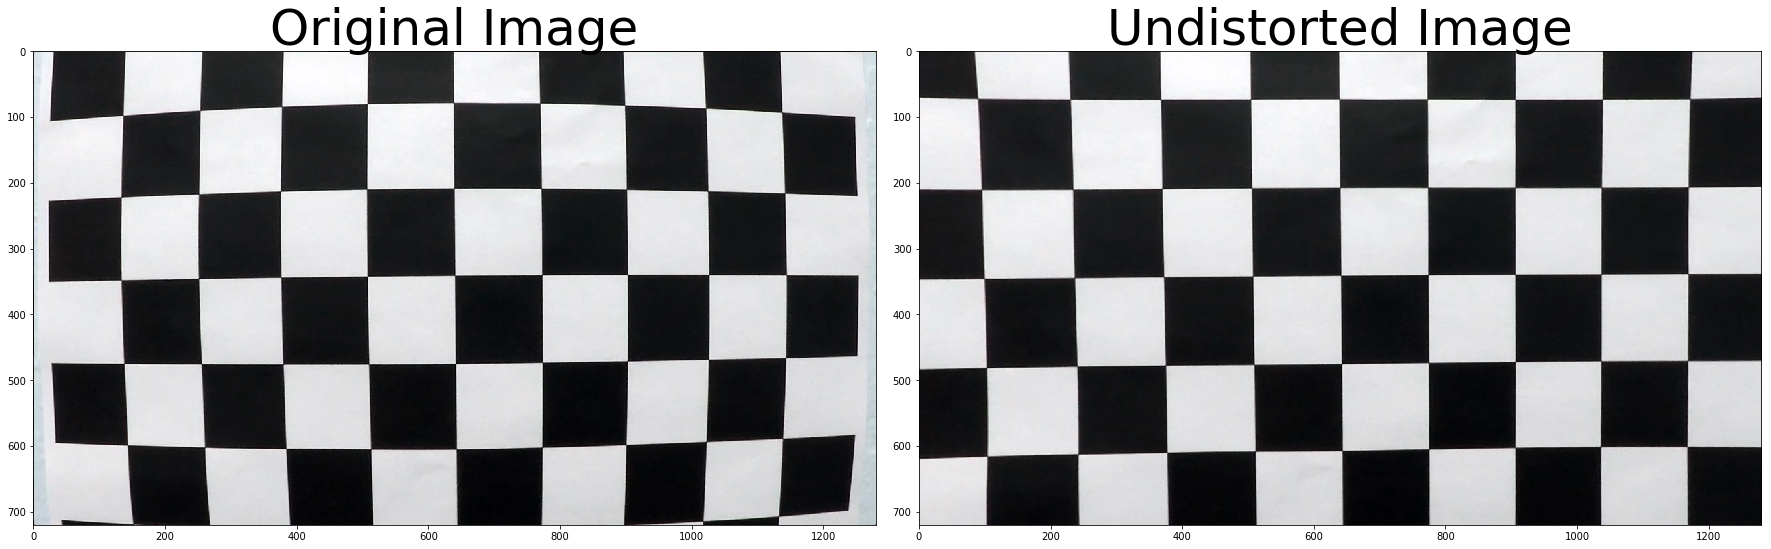

In [1]:
#importing some useful packages
%matplotlib inline
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Get objpoints and imgpoints
def get_corners(ny, nx):
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny,0:nx].T.reshape(-1,2)
    objpoints = []
    imgpoints = []
    images = glob.glob('camera_cal/*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # get the chess board corner
        ret, corners = cv2.findChessboardCorners(gray, (ny, nx), None)

        if ret == True:
            print(fname)
            objpoints.append(objp)
            imgpoints.append(corners)

            cv2.drawChessboardCorners(img, (ny, nx), corners, ret)
            #plt.imshow(img)
            #plt.show()
    return objpoints, imgpoints

# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# calculate corners
objpoints, imgpoints = get_corners(6, 9)
# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
# get the undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline (single images)
I'll show lane detection pipeline for single images as follows.

### undistorted road image

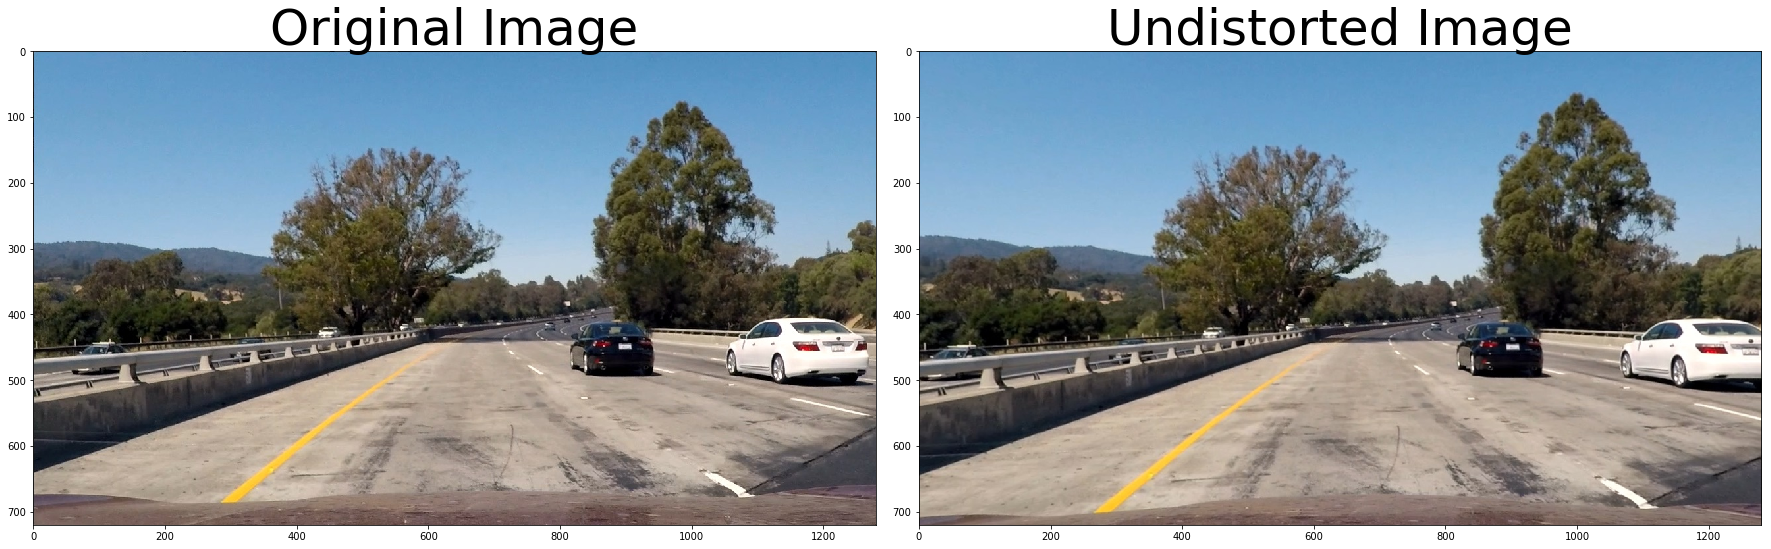

In [207]:
#reading in an image
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# get the undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color transoformation and gradients image

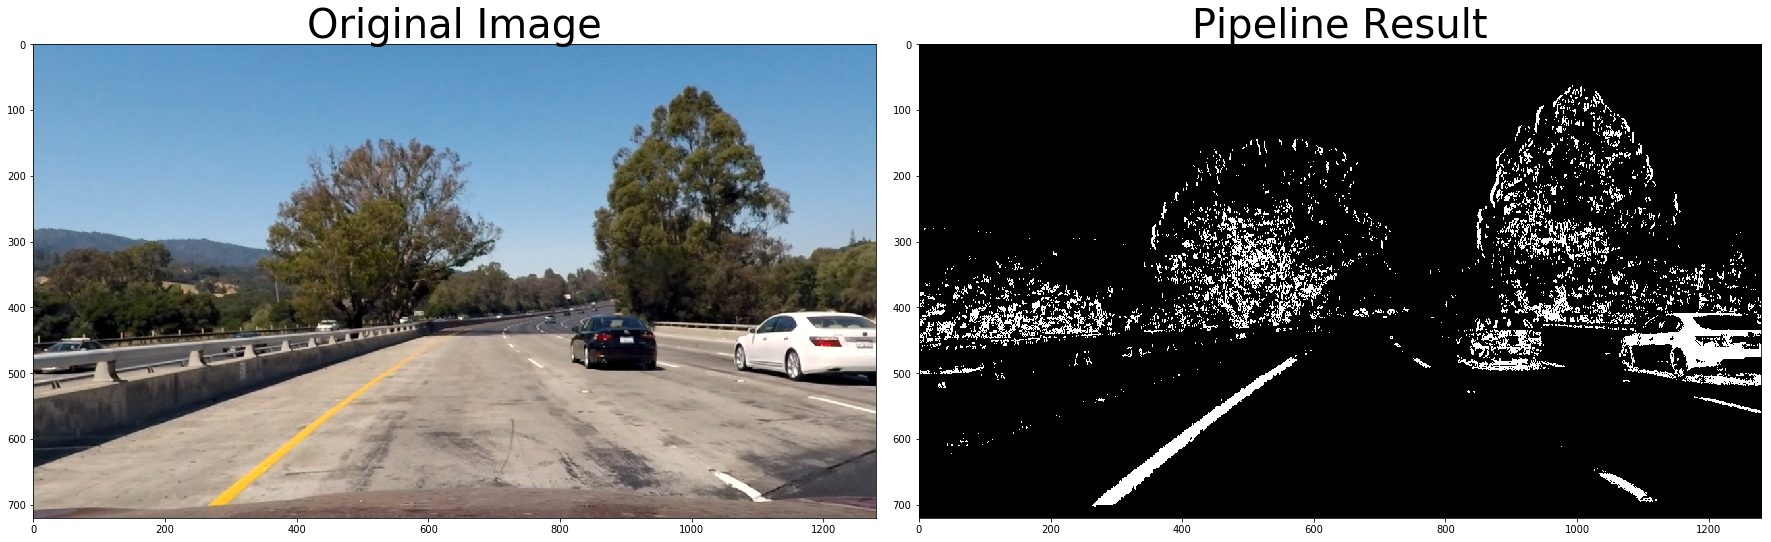

In [216]:
def pipeline(img, s_thresh=(170, 255), l_thresh=(240, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (l_binary == 1)] = 1
    return color_binary, combined_binary
    
color_binary, combined_binary = pipeline(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective transoformation

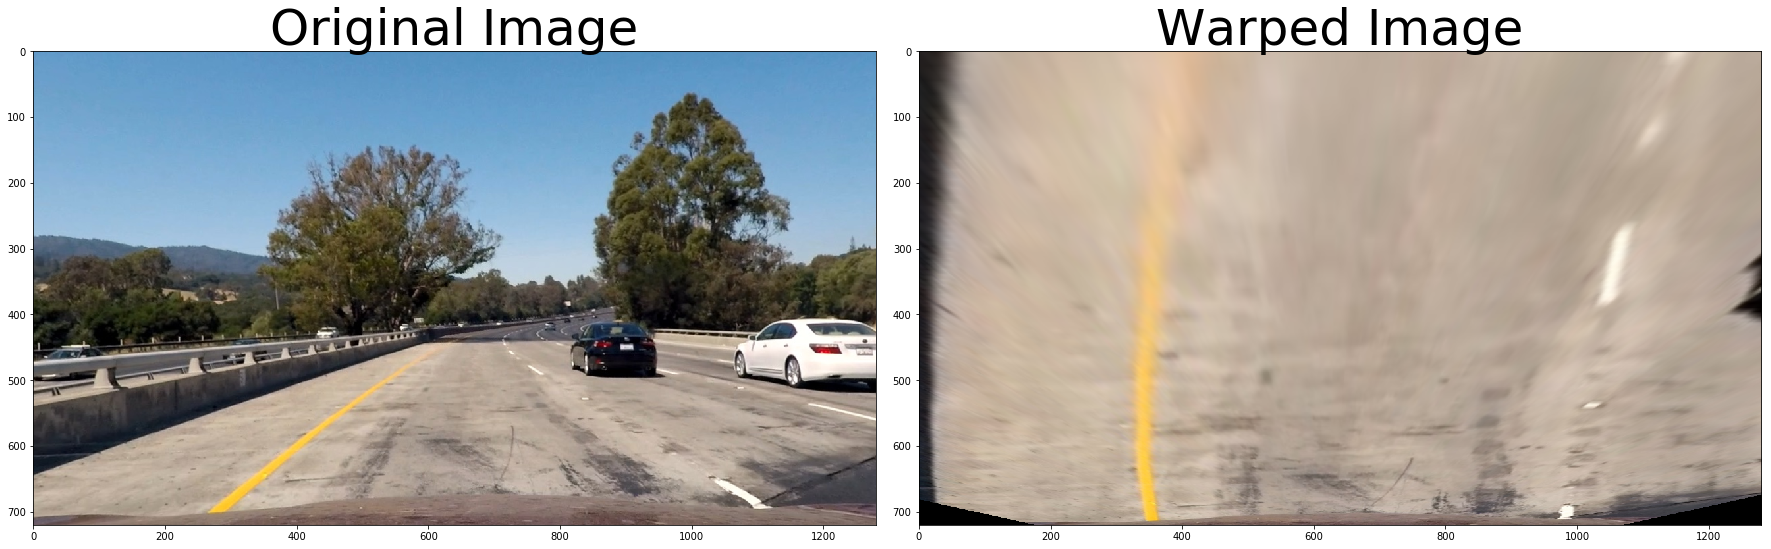

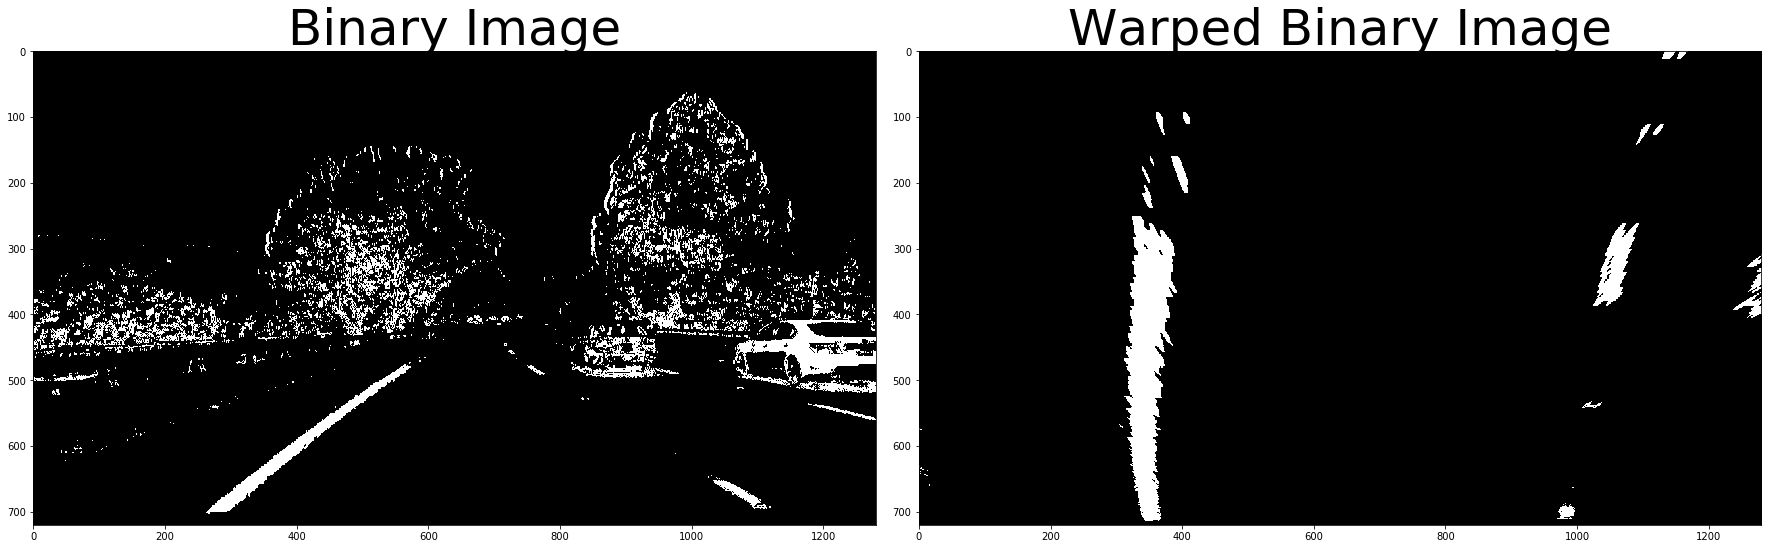

In [229]:
def warp_transform(img):
    img_size = img.shape
    src = np.float32(
        [[(img_size[1] / 2) - 55, img_size[0] / 2 + 100],
        [((img_size[1] / 6) - 10), img_size[0]],
        [(img_size[1] * 5 / 6) + 60, img_size[0]],
        [(img_size[1] / 2 + 55), img_size[0] / 2 + 100]])
    dst = np.float32(
        [[(img_size[1] / 4), 0],
        [(img_size[1] / 4), img_size[0]],
        [(img_size[1] * 3 / 4), img_size[0]],
        [(img_size[1] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
    #cv2.polylines(warped, dst, True, (255, 255, 255), thickness=2)
    
    return warped, M

top_down, perspective_M = warp_transform(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

top_down_bin, perspective_M = warp_transform(combined_binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Binary Image', fontsize=50)
ax2.imshow(top_down_bin, cmap='gray')
ax2.set_title('Warped Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Identifying lane-line pixels and fitting

curvature of left lane = 2398.1266343759025
curvature of right lane = 5062.988492364484
position from center = 0.12854696472056165


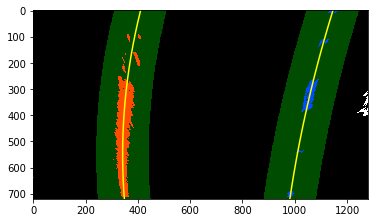

In [219]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fitx = ploty**2 * left_fit[0] + ploty * left_fit[1] + left_fit[2]
    right_fitx = ploty**2 * right_fit[0] + ploty * right_fit[1] + right_fit[2]
    
    """
    if len(lefty) == 0 or len(righty) == 0:
        left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
        right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
        left_fitx = ploty**2 * left_fit[0] + ploty * left_fit[1] + left_fit[2]
        right_fitx = ploty**2 * right_fit[0] + ploty * right_fit[1] + right_fit[2]
    elif len(lefty) > len(righty):
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = left_fit 
        left_fitx = ploty**2 * left_fit[0] + ploty * left_fit[1] + left_fit[2]
        right_fitx = ploty**2 * right_fit[0] + ploty * right_fit[1] + right_fit[2] + (rightx[0] - leftx[0])
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        left_fit = right_fit 
        left_fitx = ploty**2 * left_fit[0] + ploty * left_fit[1] + left_fit[2] - (rightx[0] - leftx[0])
        right_fitx = ploty**2 * right_fit[0] + ploty * right_fit[1] + right_fit[2] 
    """
    
    # calculate curvature
    l_curvature, r_curvature = measure_curvature_pixels(left_fit, right_fit, ploty)
    
    # calculate car position from the center point
    xm_per_pix = 3.7/700
    mid_pt = left_fitx[-1] + (right_fitx[-1] - left_fitx[-1]) // 2
    pos = (mid_pt - (img_shape[1] // 2)) * xm_per_pix
    
    return left_fitx, right_fitx, ploty, l_curvature, r_curvature, pos

def measure_curvature_pixels(left_fit, right_fit, ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 
    
    # calculate curvature
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curvature = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curvature = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curvature, right_curvature

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, l_curvature, r_curvature, pos = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty, l_curvature, r_curvature, pos

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx, ploty, l_curvature, r_curvature, pos = search_around_poly(top_down_bin)
print('curvature of left lane = {}'.format(l_curvature))
print('curvature of right lane = {}'.format(r_curvature))
print('position from center = {}'.format(pos))

# View your output
plt.imshow(result)

### Visualization

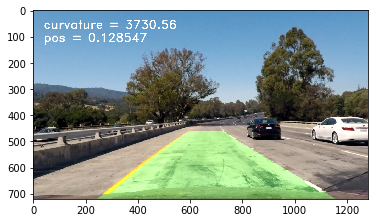

In [220]:
def visualize_lane(undistorted, top_down_bin, left_fitx, right_fitx, ploty, perspective_M, l_curvature, r_curvature, pos):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(perspective_M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (top_down_bin.shape[1], top_down_bin.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    text = 'curvature = {:.6}'.format((l_curvature + r_curvature) / 2) 
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(result, text, (40,70), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    text = 'pos = {:.6}'.format(pos) 
    cv2.putText(result, text, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return result
result = visualize_lane(undistorted, top_down_bin, left_fitx, right_fitx, ploty, perspective_M, l_curvature, r_curvature, pos)
plt.imshow(result)

### Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [221]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # get the undistorted image
    undistorted = cal_undistort(img, objpoints, imgpoints)
    # get lane binary image
    color_binary, combined_binary = pipeline(undistorted)
    #plt.imshow(combined_binary)
    #plt.show()
    #plt.imshow(color_binary)
    #plt.show()
    # Perspective transformation 
    top_down_bin, perspective_M = warp_transform(combined_binary)
    # lane finding and fitting
    result, left_fitx, right_fitx, ploty, l_curvature, r_curvature, pos = search_around_poly(top_down_bin)
    # visualize
    visualized_img = visualize_lane(undistorted, top_down_bin, left_fitx, right_fitx, ploty, perspective_M,
                                   l_curvature, r_curvature, pos)
    
    return visualized_img

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<16:14,  1.29it/s]


  0%|          | 2/1261 [00:01<16:13,  1.29it/s]


  0%|          | 3/1261 [00:02<16:14,  1.29it/s]


  0%|          | 4/1261 [00:03<16:11,  1.29it/s]


  0%|          | 5/1261 [00:03<16:11,  1.29it/s]


  0%|          | 6/1261 [00:04<16:11,  1.29it/s]


  1%|          | 7/1261 [00:05<16:13,  1.29it/s]


  1%|          | 8/1261 [00:06<16:12,  1.29it/s]


  1%|          | 9/1261 [00:06<16:12,  1.29it/s]


  1%|          | 10/1261 [00:07<16:09,  1.29it/s]


  1%|          | 11/1261 [00:08<16:08,  1.29it/s]


  1%|          | 12/1261 [00:09<16:08,  1.29it/s]


  1%|          | 13/1261 [00:10<16:06,  1.29it/s]


  1%|          | 14/1261 [00:10<16:05,  1.29it/s]


  1%|          | 15/1261 [00:11<16:07,  1.29it/s]


  1%|▏         | 16/1261 [00:12<16:06,  1.29it/s]


  1%|▏         | 17/1261 [00:13<16:05,  1.29it/s]


  1%|▏         | 18/1261 [00:13<16:03,  1.29it/s]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [01:43<14:28,  1.30it/s]


 11%|█         | 135/1261 [01:43<14:27,  1.30it/s]


 11%|█         | 136/1261 [01:44<14:26,  1.30it/s]


 11%|█         | 137/1261 [01:45<14:25,  1.30it/s]


 11%|█         | 138/1261 [01:46<14:25,  1.30it/s]


 11%|█         | 139/1261 [01:47<14:24,  1.30it/s]


 11%|█         | 140/1261 [01:47<14:23,  1.30it/s]


 11%|█         | 141/1261 [01:48<14:22,  1.30it/s]


 11%|█▏        | 142/1261 [01:49<14:21,  1.30it/s]


 11%|█▏        | 143/1261 [01:50<14:20,  1.30it/s]


 11%|█▏        | 144/1261 [01:50<14:20,  1.30it/s]


 11%|█▏        | 145/1261 [01:51<14:19,  1.30it/s]


 12%|█▏        | 146/1261 [01:52<14:18,  1.30it/s]


 12%|█▏        | 147/1261 [01:53<14:17,  1.30it/s]


 12%|█▏        | 148/1261 [01:53<14:16,  1.30it/s]


 12%|█▏        | 149/1261 [01:54<14:15,  1.30it/s]


 12%|█▏        | 150/1261 [01:55<14:15,  1.30it/s]


 12%|█▏        | 151/1261 [01:56<14:14,  1.30it/s]


 12%|█▏        | 152/1261 [01:56<14:13,  1.30i

 21%|██        | 266/1261 [03:23<12:41,  1.31it/s]


 21%|██        | 267/1261 [03:24<12:40,  1.31it/s]


 21%|██▏       | 268/1261 [03:25<12:40,  1.31it/s]


 21%|██▏       | 269/1261 [03:25<12:39,  1.31it/s]


 21%|██▏       | 270/1261 [03:26<12:38,  1.31it/s]


 21%|██▏       | 271/1261 [03:27<12:37,  1.31it/s]


 22%|██▏       | 272/1261 [03:28<12:36,  1.31it/s]


 22%|██▏       | 273/1261 [03:28<12:36,  1.31it/s]


 22%|██▏       | 274/1261 [03:29<12:35,  1.31it/s]


 22%|██▏       | 275/1261 [03:30<12:34,  1.31it/s]


 22%|██▏       | 276/1261 [03:31<12:33,  1.31it/s]


 22%|██▏       | 277/1261 [03:31<12:32,  1.31it/s]


 22%|██▏       | 278/1261 [03:32<12:32,  1.31it/s]


 22%|██▏       | 279/1261 [03:33<12:31,  1.31it/s]


 22%|██▏       | 280/1261 [03:34<12:30,  1.31it/s]


 22%|██▏       | 281/1261 [03:34<12:29,  1.31it/s]


 22%|██▏       | 282/1261 [03:35<12:29,  1.31it/s]


 22%|██▏       | 283/1261 [03:36<12:28,  1.31it/s]


 23%|██▎       | 284/1261 [03:37<12:27,  1.31i

 32%|███▏      | 398/1261 [05:05<11:01,  1.30it/s]


 32%|███▏      | 399/1261 [05:05<11:00,  1.30it/s]


 32%|███▏      | 400/1261 [05:06<11:00,  1.30it/s]


 32%|███▏      | 401/1261 [05:07<10:59,  1.30it/s]


 32%|███▏      | 402/1261 [05:08<10:58,  1.30it/s]


 32%|███▏      | 403/1261 [05:09<10:57,  1.30it/s]


 32%|███▏      | 404/1261 [05:09<10:57,  1.30it/s]


 32%|███▏      | 405/1261 [05:10<10:56,  1.30it/s]


 32%|███▏      | 406/1261 [05:11<10:55,  1.30it/s]


 32%|███▏      | 407/1261 [05:12<10:54,  1.30it/s]


 32%|███▏      | 408/1261 [05:12<10:54,  1.30it/s]


 32%|███▏      | 409/1261 [05:13<10:53,  1.30it/s]


 33%|███▎      | 410/1261 [05:14<10:52,  1.30it/s]


 33%|███▎      | 411/1261 [05:15<10:51,  1.30it/s]


 33%|███▎      | 412/1261 [05:15<10:50,  1.30it/s]


 33%|███▎      | 413/1261 [05:16<10:50,  1.30it/s]


 33%|███▎      | 414/1261 [05:17<10:49,  1.30it/s]


 33%|███▎      | 415/1261 [05:18<10:48,  1.30it/s]


 33%|███▎      | 416/1261 [05:18<10:47,  1.30i

 42%|████▏     | 530/1261 [06:47<09:21,  1.30it/s]


 42%|████▏     | 531/1261 [06:47<09:20,  1.30it/s]


 42%|████▏     | 532/1261 [06:48<09:20,  1.30it/s]


 42%|████▏     | 533/1261 [06:49<09:19,  1.30it/s]


 42%|████▏     | 534/1261 [06:50<09:18,  1.30it/s]


 42%|████▏     | 535/1261 [06:51<09:17,  1.30it/s]


 43%|████▎     | 536/1261 [06:51<09:16,  1.30it/s]


 43%|████▎     | 537/1261 [06:52<09:16,  1.30it/s]


 43%|████▎     | 538/1261 [06:53<09:15,  1.30it/s]


 43%|████▎     | 539/1261 [06:54<09:14,  1.30it/s]


 43%|████▎     | 540/1261 [06:54<09:13,  1.30it/s]


 43%|████▎     | 541/1261 [06:55<09:13,  1.30it/s]


 43%|████▎     | 542/1261 [06:56<09:12,  1.30it/s]


 43%|████▎     | 543/1261 [06:57<09:11,  1.30it/s]


 43%|████▎     | 544/1261 [06:57<09:10,  1.30it/s]


 43%|████▎     | 545/1261 [06:58<09:10,  1.30it/s]


 43%|████▎     | 546/1261 [06:59<09:09,  1.30it/s]


 43%|████▎     | 547/1261 [07:00<09:08,  1.30it/s]


 43%|████▎     | 548/1261 [07:00<09:07,  1.30i

 52%|█████▏    | 662/1261 [08:29<07:40,  1.30it/s]


 53%|█████▎    | 663/1261 [08:29<07:39,  1.30it/s]


 53%|█████▎    | 664/1261 [08:30<07:39,  1.30it/s]


 53%|█████▎    | 665/1261 [08:31<07:38,  1.30it/s]


 53%|█████▎    | 666/1261 [08:32<07:37,  1.30it/s]


 53%|█████▎    | 667/1261 [08:33<07:36,  1.30it/s]


 53%|█████▎    | 668/1261 [08:33<07:36,  1.30it/s]


 53%|█████▎    | 669/1261 [08:34<07:35,  1.30it/s]


 53%|█████▎    | 670/1261 [08:35<07:34,  1.30it/s]


 53%|█████▎    | 671/1261 [08:36<07:33,  1.30it/s]


 53%|█████▎    | 672/1261 [08:36<07:33,  1.30it/s]


 53%|█████▎    | 673/1261 [08:37<07:32,  1.30it/s]


 53%|█████▎    | 674/1261 [08:38<07:31,  1.30it/s]


 54%|█████▎    | 675/1261 [08:39<07:30,  1.30it/s]


 54%|█████▎    | 676/1261 [08:40<07:30,  1.30it/s]


 54%|█████▎    | 677/1261 [08:40<07:29,  1.30it/s]


 54%|█████▍    | 678/1261 [08:41<07:28,  1.30it/s]


 54%|█████▍    | 679/1261 [08:42<07:27,  1.30it/s]


 54%|█████▍    | 680/1261 [08:43<07:26,  1.30i

 63%|██████▎   | 794/1261 [10:11<05:59,  1.30it/s]


 63%|██████▎   | 795/1261 [10:12<05:58,  1.30it/s]


 63%|██████▎   | 796/1261 [10:13<05:58,  1.30it/s]


 63%|██████▎   | 797/1261 [10:13<05:57,  1.30it/s]


 63%|██████▎   | 798/1261 [10:14<05:56,  1.30it/s]


 63%|██████▎   | 799/1261 [10:15<05:55,  1.30it/s]


 63%|██████▎   | 800/1261 [10:16<05:55,  1.30it/s]


 64%|██████▎   | 801/1261 [10:17<05:54,  1.30it/s]


 64%|██████▎   | 802/1261 [10:17<05:53,  1.30it/s]


 64%|██████▎   | 803/1261 [10:18<05:52,  1.30it/s]


 64%|██████▍   | 804/1261 [10:19<05:52,  1.30it/s]


 64%|██████▍   | 805/1261 [10:20<05:51,  1.30it/s]


 64%|██████▍   | 806/1261 [10:21<05:50,  1.30it/s]


 64%|██████▍   | 807/1261 [10:21<05:49,  1.30it/s]


 64%|██████▍   | 808/1261 [10:22<05:49,  1.30it/s]


 64%|██████▍   | 809/1261 [10:23<05:48,  1.30it/s]


 64%|██████▍   | 810/1261 [10:24<05:47,  1.30it/s]


 64%|██████▍   | 811/1261 [10:25<05:46,  1.30it/s]


 64%|██████▍   | 812/1261 [10:25<05:46,  1.30i

 73%|███████▎  | 926/1261 [11:54<04:18,  1.30it/s]


 74%|███████▎  | 927/1261 [11:55<04:17,  1.30it/s]


 74%|███████▎  | 928/1261 [11:56<04:16,  1.30it/s]


 74%|███████▎  | 929/1261 [11:56<04:16,  1.30it/s]


 74%|███████▍  | 930/1261 [11:57<04:15,  1.30it/s]


 74%|███████▍  | 931/1261 [11:58<04:14,  1.30it/s]


 74%|███████▍  | 932/1261 [11:59<04:13,  1.30it/s]


 74%|███████▍  | 933/1261 [12:00<04:13,  1.30it/s]


 74%|███████▍  | 934/1261 [12:00<04:12,  1.30it/s]


 74%|███████▍  | 935/1261 [12:01<04:11,  1.30it/s]


 74%|███████▍  | 936/1261 [12:02<04:10,  1.30it/s]


 74%|███████▍  | 937/1261 [12:03<04:10,  1.30it/s]


 74%|███████▍  | 938/1261 [12:04<04:09,  1.30it/s]


 74%|███████▍  | 939/1261 [12:04<04:08,  1.30it/s]


 75%|███████▍  | 940/1261 [12:05<04:07,  1.30it/s]


 75%|███████▍  | 941/1261 [12:06<04:07,  1.30it/s]


 75%|███████▍  | 942/1261 [12:07<04:06,  1.30it/s]


 75%|███████▍  | 943/1261 [12:07<04:05,  1.30it/s]


 75%|███████▍  | 944/1261 [12:08<04:04,  1.30i

 84%|████████▍ | 1057/1261 [13:36<02:37,  1.29it/s]


 84%|████████▍ | 1058/1261 [13:37<02:36,  1.29it/s]


 84%|████████▍ | 1059/1261 [13:37<02:36,  1.29it/s]


 84%|████████▍ | 1060/1261 [13:38<02:35,  1.29it/s]


 84%|████████▍ | 1061/1261 [13:39<02:34,  1.29it/s]


 84%|████████▍ | 1062/1261 [13:40<02:33,  1.29it/s]


 84%|████████▍ | 1063/1261 [13:40<02:32,  1.29it/s]


 84%|████████▍ | 1064/1261 [13:41<02:32,  1.29it/s]


 84%|████████▍ | 1065/1261 [13:42<02:31,  1.29it/s]


 85%|████████▍ | 1066/1261 [13:43<02:30,  1.29it/s]


 85%|████████▍ | 1067/1261 [13:43<02:29,  1.29it/s]


 85%|████████▍ | 1068/1261 [13:44<02:29,  1.29it/s]


 85%|████████▍ | 1069/1261 [13:45<02:28,  1.29it/s]


 85%|████████▍ | 1070/1261 [13:46<02:27,  1.29it/s]


 85%|████████▍ | 1071/1261 [13:47<02:26,  1.29it/s]


 85%|████████▌ | 1072/1261 [13:47<02:25,  1.30it/s]


 85%|████████▌ | 1073/1261 [13:48<02:25,  1.30it/s]


 85%|████████▌ | 1074/1261 [13:49<02:24,  1.30it/s]


 85%|████████▌ | 1075/1261 [

 94%|█████████▍| 1187/1261 [15:16<00:57,  1.29it/s]


 94%|█████████▍| 1188/1261 [15:17<00:56,  1.29it/s]


 94%|█████████▍| 1189/1261 [15:18<00:55,  1.29it/s]


 94%|█████████▍| 1190/1261 [15:19<00:54,  1.29it/s]


 94%|█████████▍| 1191/1261 [15:19<00:54,  1.29it/s]


 95%|█████████▍| 1192/1261 [15:20<00:53,  1.29it/s]


 95%|█████████▍| 1193/1261 [15:21<00:52,  1.29it/s]


 95%|█████████▍| 1194/1261 [15:22<00:51,  1.29it/s]


 95%|█████████▍| 1195/1261 [15:22<00:50,  1.29it/s]


 95%|█████████▍| 1196/1261 [15:23<00:50,  1.29it/s]


 95%|█████████▍| 1197/1261 [15:24<00:49,  1.29it/s]


 95%|█████████▌| 1198/1261 [15:25<00:48,  1.29it/s]


 95%|█████████▌| 1199/1261 [15:26<00:47,  1.29it/s]


 95%|█████████▌| 1200/1261 [15:26<00:47,  1.29it/s]


 95%|█████████▌| 1201/1261 [15:27<00:46,  1.29it/s]


 95%|█████████▌| 1202/1261 [15:28<00:45,  1.29it/s]


 95%|█████████▌| 1203/1261 [15:29<00:44,  1.29it/s]


 95%|█████████▌| 1204/1261 [15:29<00:44,  1.29it/s]


 96%|█████████▌| 1205/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 17min 1s, sys: 2min 36s, total: 19min 38s
Wall time: 16min 14s


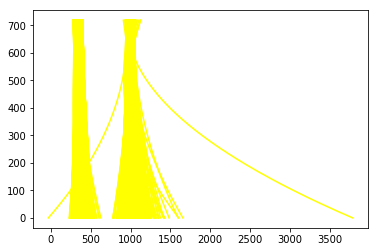

In [222]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline.

In [223]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))